In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
#Datos de Diabetes
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')

#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns


#Definicion de datos enteros.
for col in datos_diabetes.columns:
    #if datos_diabetes[col].dtype == 'float64':
    datos_diabetes[col] = datos_diabetes[col].astype(int)



In [7]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    #print(df_eval_stats)
    
    return  df_eval_stats, fig#eval_stats['train']['F1'], eval_stats['test']['F1']

In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter 

X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [5]:

os_us = SMOTE()
X_train_res_SMOTE, y_train_res_SMOTE= os_us.fit_resample(X_train, y_train)

print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_SMOTE)))

before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})


In [4]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

(           train  test
 Exactitud   0.85  0.85
 F1          0.32  0.32
 APS         0.45  0.45
 ROC AUC     0.82  0.82,
 <Figure size 2000x600 with 3 Axes>)

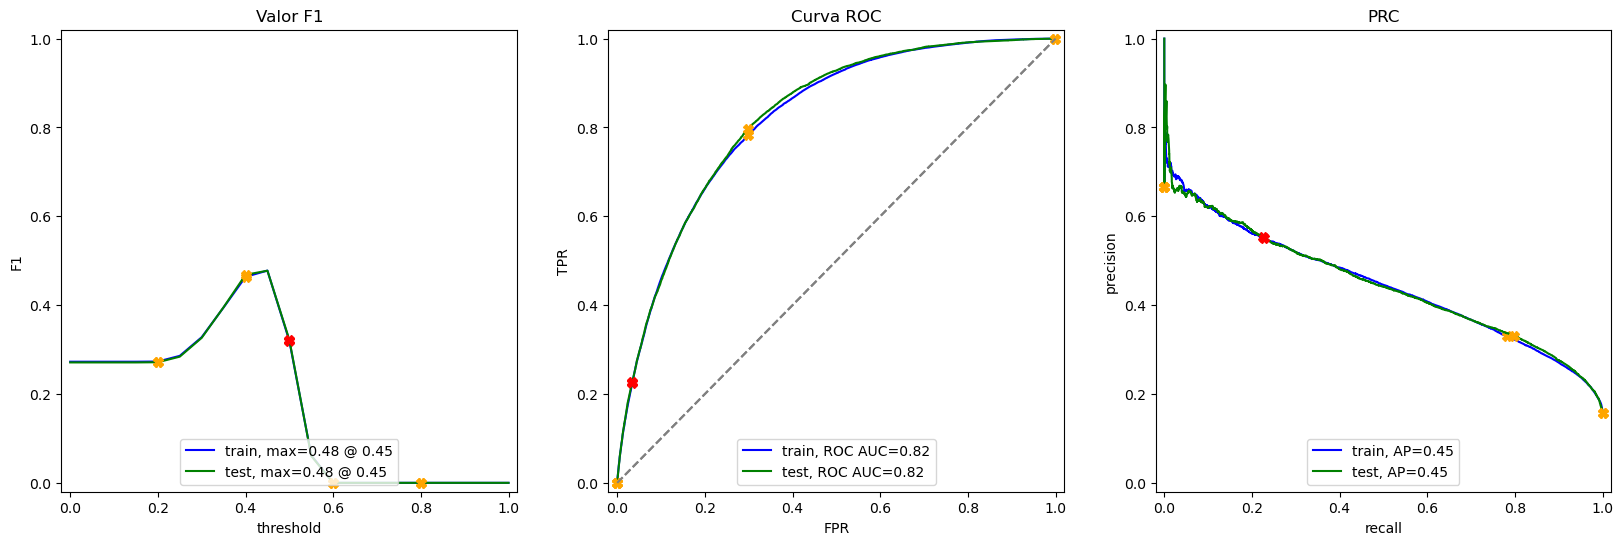

In [8]:
evaluate_model(clf, X_train, y_train, X_test, y_test)

In [9]:
adaboost_SMOTE = AdaBoostClassifier(n_estimators=100, random_state=0)
adaboost_SMOTE.fit(X_train_res_SMOTE, y_train_res_SMOTE)

AdaBoostClassifier(n_estimators=100, random_state=0)

(           train  test
 Exactitud   0.74  0.72
 F1          0.74  0.45
 APS         0.80  0.39
 ROC AUC     0.82  0.79,
 <Figure size 2000x600 with 3 Axes>)

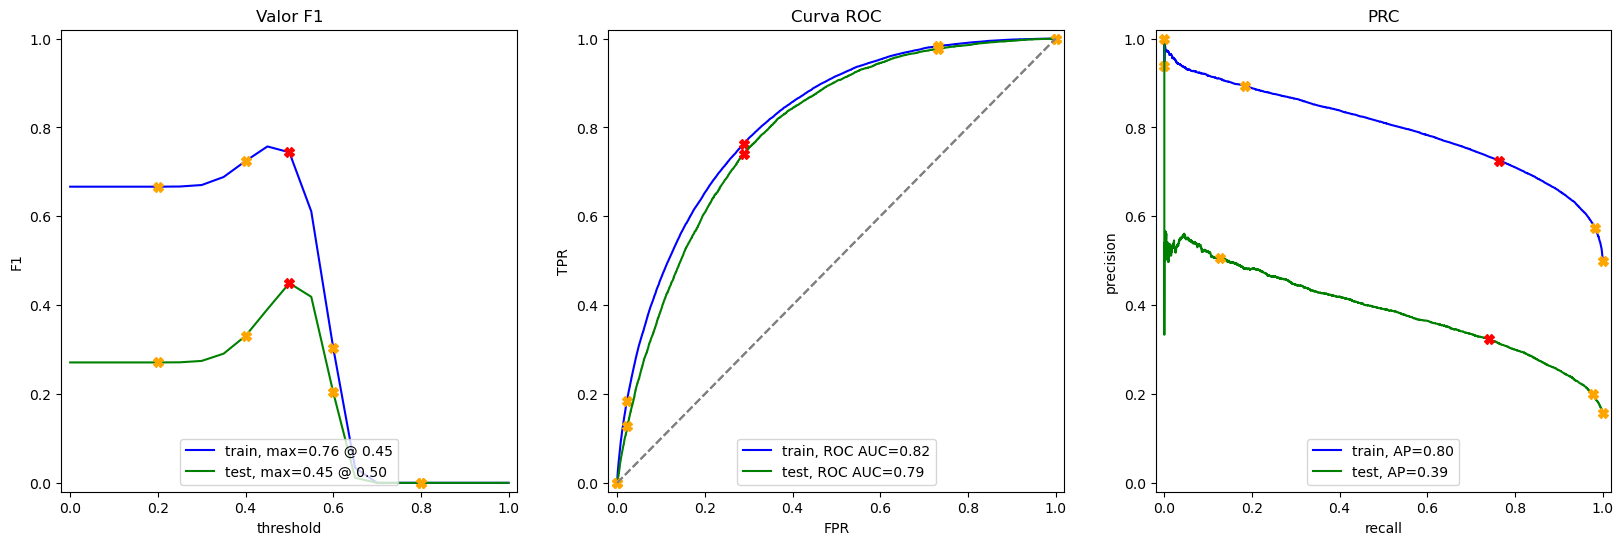

In [10]:
evaluate_model(adaboost_SMOTE, X_train_res_SMOTE, y_train_res_SMOTE, X_test, y_test)

In [11]:
xgboost_unbalanced = xgb.XGBClassifier()

param_grid = {
    'max_depth': [3, 5, 7],               #profundidad maxima de los arboles
    'n_estimators': [50, 100, 200],       # iteraciones/arboles del algoritmo
    'learning_rate': [0.01, 0.1, 0.3],    # tasa de aprendizaje (peso de regularizacion)
    'subsample': [0.8, 1.0],              # tamano del remuestreo
    'colsample_bytree': [0.6, 1.0]        # Carateristicass del arbol
}


random_search = RandomizedSearchCV(xgboost_unbalanced, param_distributions=param_grid, n_iter= 100 , cv= 5 , scoring= 'f1' ) 
random_search.fit(X_train, y_train) 

print ( "Mejor conjunto de hiperparámetros: " , random_search.best_params_) 
print ( "Mejor puntuación: " , random_search.best_score_)


Mejor conjunto de hiperparámetros:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Mejor puntuación:  0.3128858272809307


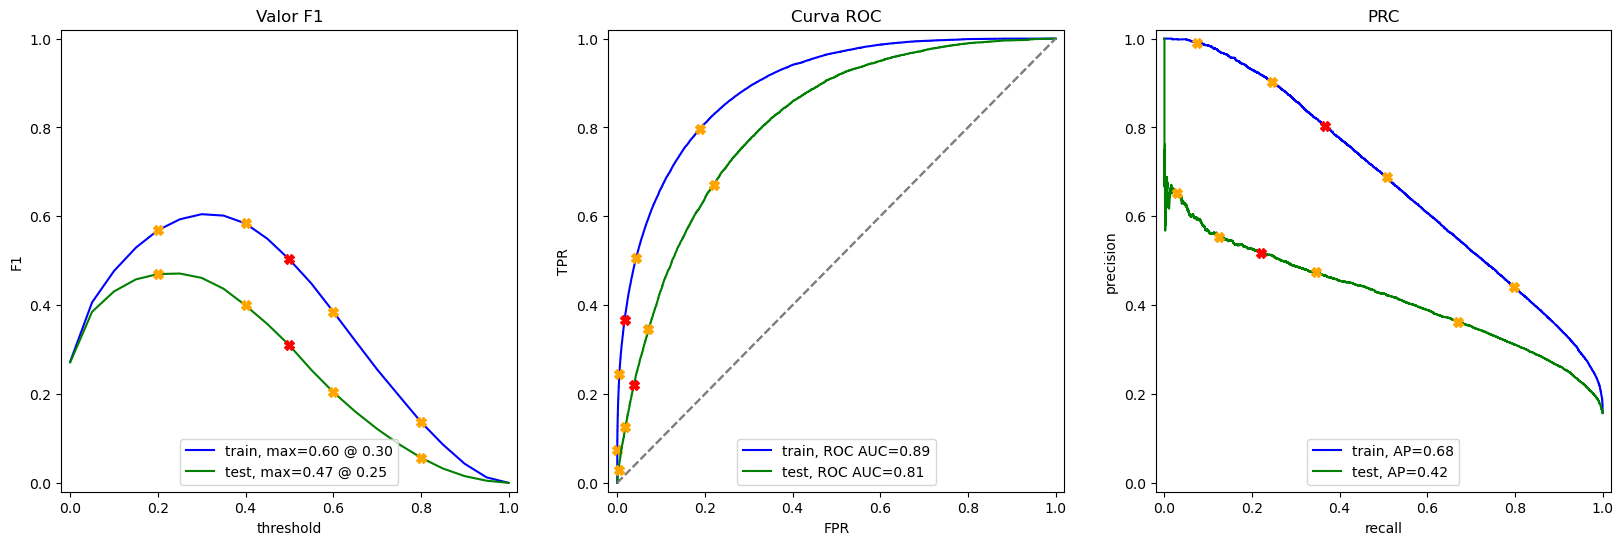

In [12]:
with open("xgboost_unbalanced.pkl", 'wb') as file:
    pickle.dump(random_search.best_estimator_, file)

with open("xgboost_unbalanced.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig =evaluate_model(model, X_train, y_train, X_test, y_test)

df_metrics.to_csv('metrics_xgboost_unbalanced.csv')

with open('fig_xgboost_unbalanced.pkl', 'wb') as f:
    pickle.dump(fig, f)

In [13]:
xgboost_balanced = xgb.XGBClassifier()
pos_class_weight = (len(y) - np.sum(y)) / np.sum(y)
param_grid = {
    'max_depth': [3, 5, 7],               #profundidad maxima de los arboles
    'n_estimators': [50, 100, 200],       # iteraciones/arboles del algoritmo
    'learning_rate': [0.01, 0.1, 0.3],    # tasa de aprendizaje (peso de regularizacion)
    'subsample': [0.8, 1.0],              # tamano del remuestreo
    'scale_pos_weight' : [pos_class_weight],
    'colsample_bytree': [0.6, 1.0]        # Carateristicass del arbol
}


random_search_balanced = RandomizedSearchCV(xgboost_balanced, param_distributions=param_grid, n_iter= 100 , cv= 5 , scoring= 'f1' ) 
random_search_balanced.fit(X_train, y_train) 

print ( "Mejor conjunto de hiperparámetros: " , random_search_balanced.best_params_) 
print ( "Mejor puntuación: " , random_search_balanced.best_score_)


Mejor conjunto de hiperparámetros:  {'subsample': 1.0, 'scale_pos_weight': 5.345648748030118, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Mejor puntuación:  0.4722433452737061


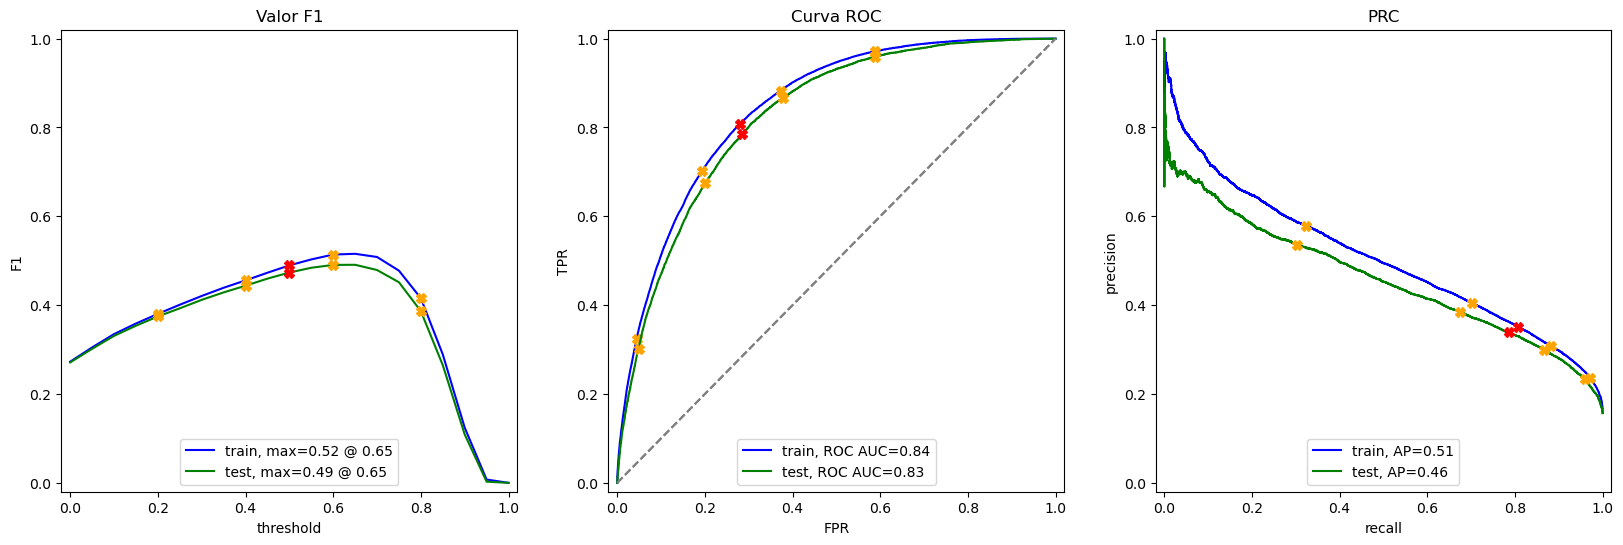

In [14]:
with open("xgboost_balanced.pkl", 'wb') as file:
    pickle.dump(random_search_balanced.best_estimator_, file)

with open("xgboost_balanced.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig =evaluate_model(model, X_train, y_train, X_test, y_test)

df_metrics.to_csv('metrics_xgboost_balanced.csv')

with open('fig_xgboost_balanced.pkl', 'wb') as f:
    pickle.dump(fig, f)

In [15]:
# 4 best

X_train_best4= X_train[['bmi', 'age', 'income', 'genHlth']]
X_test_best4 =X_test[['bmi', 'age', 'income', 'genHlth']]

xgboost_balanced_best4 = xgb.XGBClassifier()
pos_class_weight = (len(y) - np.sum(y)) / np.sum(y)
param_grid = {
    'max_depth': [3, 5, 7],               #profundidad maxima de los arboles
    'n_estimators': [50, 100, 200],       # iteraciones/arboles del algoritmo
    'learning_rate': [0.01, 0.1, 0.3],    # tasa de aprendizaje (peso de regularizacion)
    'subsample': [0.8, 1.0],              # tamano del remuestreo
    'scale_pos_weight' : [pos_class_weight],
    'colsample_bytree': [0.6, 1.0]        # Carateristicass del arbol
}


random_search_balanced_best4 = RandomizedSearchCV(xgboost_balanced_best4, param_distributions=param_grid, n_iter= 100 , cv= 5 , scoring= 'f1' ) 
random_search_balanced_best4.fit(X_train_best4, y_train) 

print ( "Mejor conjunto de hiperparámetros: " , random_search_balanced_best4.best_params_) 
print ( "Mejor puntuación: " , random_search_balanced_best4.best_score_)

Mejor conjunto de hiperparámetros:  {'subsample': 1.0, 'scale_pos_weight': 5.345648748030118, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Mejor puntuación:  0.4480420041159559


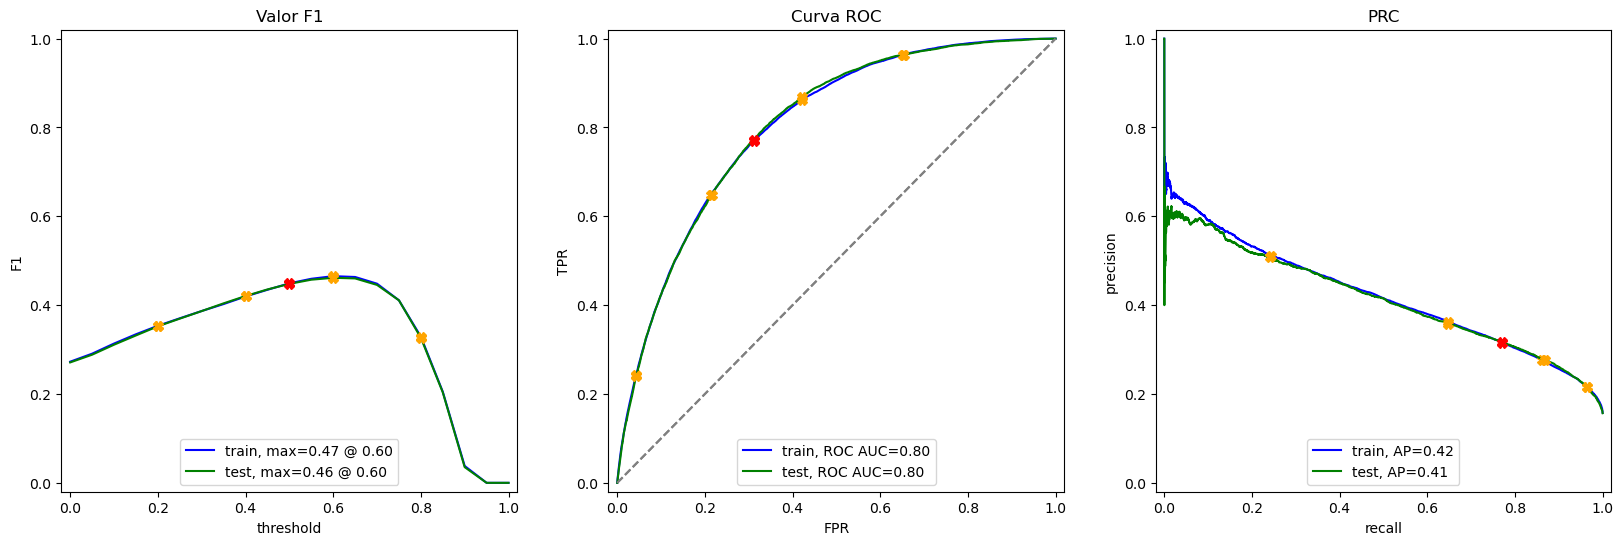

In [16]:
with open("xgboost_balanced_best4.pkl", 'wb') as file:
    pickle.dump(random_search_balanced_best4.best_estimator_, file)

with open("xgboost_balanced_best4.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig =evaluate_model(model, X_train_best4, y_train, X_test_best4, y_test)

df_metrics.to_csv('metrics_xgboost_balanced_best4.csv')

with open('fig_xgboost_balanced_best4.pkl', 'wb') as f:
    pickle.dump(fig, f)